# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.756139,True,4.422977
1,1.382471,False,0.238530
2,0.271450,False,0.484912
3,1.148319,True,5.397874
4,0.848067,True,5.398431
...,...,...,...
995,0.627910,True,4.876157
996,1.916298,True,5.638743
997,2.411518,True,6.703120
998,-0.239359,False,-0.869543


<Axes: xlabel='v0'>

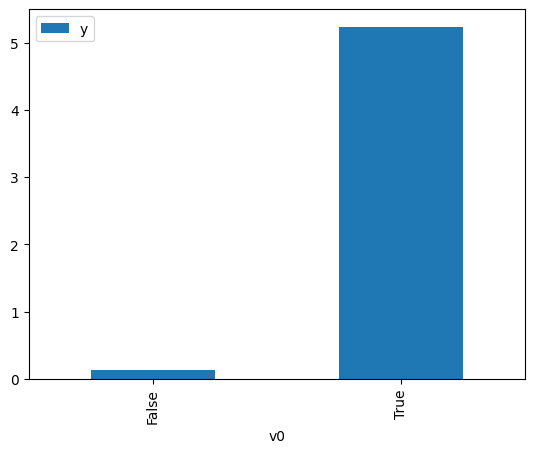

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

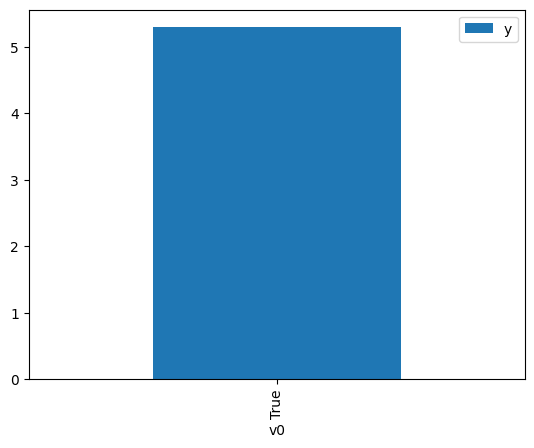

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.704107,False,0.782175,0.179696,5.564970
1,1.690602,False,0.741542,0.024223,41.283711
2,1.690602,False,0.741542,0.024223,41.283711
3,0.704107,False,0.782175,0.179696,5.564970
4,1.075991,False,-1.017738,0.087921,11.373845
...,...,...,...,...,...
995,0.124177,False,0.782905,0.440704,2.269096
996,1.263417,False,0.460902,0.059917,16.689658
997,0.167442,False,-2.159738,0.417315,2.396273
998,0.948564,False,-0.475006,0.113245,8.830391


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.205700,True,5.379939,0.063139,15.838037
1,-1.347673,True,3.631342,0.046950,21.299106
2,1.242841,True,4.878716,0.937473,1.066698
3,2.912466,True,6.884314,0.998330,1.001673
4,2.297364,True,7.376907,0.993538,1.006504
...,...,...,...,...,...
995,1.176750,True,5.174957,0.928355,1.077174
996,0.959103,True,4.640709,0.889070,1.124771
997,2.276216,True,4.538408,0.993231,1.006815
998,0.576039,True,5.098612,0.774818,1.290625


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.091e+04
Date:                Fri, 04 Aug 2023   Prob (F-statistic):                        0.00
Time:                        15:34:18   Log-Likelihood:                         -1425.5
No. Observations:                1000   AIC:                                      2855.
Df Residuals:                     998   BIC:                                      2865.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4497      0.039     11.398      0.000       0.372       0.527
x2             4.8639      0.060     80.536      0.000       4.745       4.982
==============================================================================
Omnibus:                       17.238   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.245
Skew:                          -0.242   Prob(JB):                     4.02e-05
Kurtosis:                       3.502   Cond. No.                         3.29
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""